# Gaussian Process Model for customer visitation data

This notebook models the Thasos Mall REIT Foot Traffic Index using a Gaussian Process (GP). 

In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.

A machine-learning algorithm that involves a Gaussian process uses lazy learning and a measure of the similarity between points (the kernel function) to predict the value for an unseen point from training data. The prediction is not just an estimate for that point, but also has uncertainty information—it is a one-dimensional Gaussian distribution (which is the marginal distribution at that point).

Thasos is an award-winning alternative data intelligence firm based in New York City. Founded in 2011 at MIT, Thasos transforms real-time location data from mobile phones into objective and actionable information on the performance of businesses, markets, and economies worldwide.

Thasos MallStreams products enable detailed near real-time analysis of over 95% of the malls owned or operated by the largest publicly traded retail Real Estate Investment Trusts (REITs) such as GGP (Brookfield Properties Retail Group) and SKT (Tanger Factory Outlet Centers Inc.).

The Thasos Mall REIT Foot traffic Index is seasonal with peaks on Black Friday and during the Christmas holiday period. It is expexted that this seasonality can be modelled using a Gaussian Process

## Imports

In [32]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import cufflinks as cf
from plotly.graph_objs.scatter import Line, Marker
import gpflow
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from GPModelObject import GPModelObject

from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)         # initiate notebook for offline plot

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'  # <3>
%matplotlib inline

## Visualise Portfolio

First we initialise an object using the GPModelObject class that was created for this exercise. We run the method to get the data, using the last full year for testing (Sep 2018 to Aug 2019). Training period is from August 2015 to August 2018. 

- **PX_MID:** Variable containing the total customer visitation volume (same as column y)
- **sd_f_30_12:** sd stands for special day, f for fixed for all years, 30_12 stands for 30th of Dec
- **sd_v_thanksg_plus_one:** sd stands for special day, v for variable day from year to year, thanksg_plus_one for one day after thanks-giving (which is the Black Friday)

In [3]:
# Initialise GP class
model_1 = GPModelObject()

# Get data and set testing cutoff
model_1.get_data(testing_cutoff='20180901')

,Dates,PX_MID,year,month,day,day_of_year,day_of_year_str,day_of_week,PX_MID_YD_LOG,PX_MID_YD,...,sd_f_30_12,sd_f_31_12,sd_v_thanksg,sd_v_thanksg_plus_one,sd_v_labor,sd_v_labor_plus_one,sd_v_memorial,sd_v_easter,x,y
0,2015-08-01,5622,2015,8,1,214,01-Aug,6,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5622
1,2015-08-02,4147,2015,8,2,215,02-Aug,7,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4147
2,2015-08-03,3517,2015,8,3,216,03-Aug,1,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3517
3,2015-08-04,3540,2015,8,4,217,04-Aug,2,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3540
4,2015-08-05,3621,2015,8,5,218,05-Aug,3,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,3621


Descptiptive stats for each column.

In [4]:
model_1.data.describe(include = 'all')

,Dates,PX_MID,year,month,day,day_of_year,day_of_year_str,day_of_week,PX_MID_YD_LOG,PX_MID_YD,...,sd_f_30_12,sd_f_31_12,sd_v_thanksg,sd_v_thanksg_plus_one,sd_v_labor,sd_v_labor_plus_one,sd_v_memorial,sd_v_easter,x,y
count,1491,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491,1491.000000,1126.000000,1126.000000,...,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000
unique,1491,NaN,NaN,NaN,NaN,NaN,365,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-09-08 00:00:00,NaN,NaN,NaN,NaN,NaN,03-Aug,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2015-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3518.510396,2017.120724,6.556673,15.726358,185.140845,NaN,4.003353,-0.027622,-106.943162,...,0.002683,0.002683,0.002683,0.002683,0.002683,0.002683,0.002683,0.002683,745.000000,3518.510396
std,NaN,984.216818,1.240337,3.419443,8.802393,104.562349,NaN,1.999829,0.254254,1029.424839,...,0.051743,0.051743,0.051743,0.051743,0.051743,0.051743,0.051743,0.051743,430.558939,984.216818
min,NaN,574.000000,2015.000000,1.000000,1.000000,2.000000,NaN,1.000000,-1.154624,-6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,574.000000
25%,NaN,2874.500000,2016.000000,4.000000,8.000000,95.000000,NaN,2.000000,-0.181458,-588.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.500000,2874.500000


Number of days for each year.

In [5]:
model_1.data.groupby('year').count()['Dates']

year
2015    153
2016    365
2017    365
2018    365
2019    243
Name: Dates, dtype: int64

### Visualise Data

Here we visualise the footfall in different ways:

- **Footfall by Year**: There doesn't appear to be a consistent trend 
- **Footfall by Month**: There seems to be a seasonal trent with peaks during the summer and also on November and December
- **Footfall by Day**: No clear trend.
- **Footfall by Day of Week**: There seems to be a seasonal trent with peaks on Friday, Saturday and Sunday
- **Day of Week variation**: It seems like the periodicity of the day of week seasonality is decaying. 
- **Month Variation**: It seems like the periodicity of the month is also changing through the years

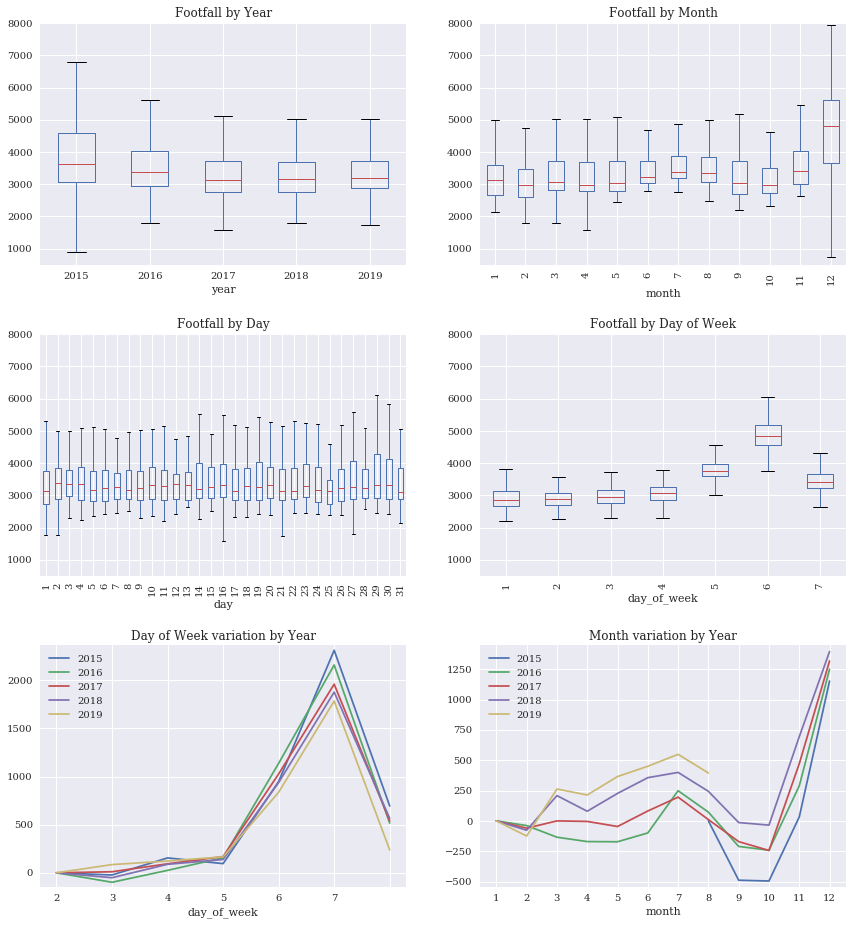

In [6]:
model_1.plot_graphs(model_1.data, col='PX_MID')

Iteractively explore the train and test sample.

In [8]:
model_1.data.iplot(data = [dict(y=model_1.data_d['PX_MID'], 
                                x=model_1.data_d['Dates'],
                                name='Train',
                               line=Line(color='rgba(255, 153, 51, 1.0)',
                                         width=0.8)),
                          dict(y=model_1.data_t['PX_MID'], 
                                x=model_1.data_t['Dates'],
                               name='Test',
                               line=Line(color='rgba(100, 153, 51, 1.0)',
                                         width=0.8))], 
                   title = 'Train and Test sample',
                   dimensions=(900, 500), 
                   vspan=dict(x0=datetime.datetime.strptime(model_1.testing_cutoff, "%Y%m%d"),
                              x1= model_1.data['Dates'].max(),
                              color='Black',
                              width=0,
                             fill= True,
                             opacity = 0.1), 
                   annotations=dict(x=0.94,
                                    y=1,
                                    showarrow=False,
                                    text="",
                                    xref="paper",
                                    yref="paper",
                                    textangle=0)
                  )

Augmented Dickey-Fuller test suggests that the series is stationary so there is no need to alter the mean function of the Gaussian Procees model.

In [9]:
# Stationarity test (Series is stationary)
ADF = adfuller(model_1.data['PX_MID'].values)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])
print('Critical Values:')
for key, value in ADF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.974412
p-value: 0.000025
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Check the yearly difference to spot special days by looking at any spikes. The ones that stand out are thanks giving, Black Friday, and Easter Sunday.

In [10]:
# Plot YoY differences - this will help identifying variable days
model_1.data.dropna(subset=['PX_MID_YD']).iplot(y='PX_MID_YD', x='Dates', 
                                                dimensions=(900, 300), 
                                                title = 'Yearly Difference');


Plot again by exluding the three special days spotted above. No more special days stand out.

In [11]:
# Plot YoY differences by excluding some special variable days
d = model_1.data[(model_1.data['sd_v_thanksg'] != 1) 
                 & (model_1.data['sd_v_thanksg_plus_one'] != 1)
                 & (model_1.data['sd_v_easter'] != 1)].copy()
d.reset_index(drop=True, inplace=True)

# Create a new yearly difference column using the method yearly_diff
model_1.yearly_diff(data=d, datecol='Dates', col='PX_MID', newcol='PX_MID_YD_2')                     
d.dropna(subset=['PX_MID_YD_2']).iplot(y='PX_MID_YD_2', x='Dates', 
                                       dimensions=(900, 300), 
                                       title = 'Yearly Difference');

### Model Construction

Clear the dictionary containing the canditate kernels.

In [12]:
# Clear kernel
model_1.kernel_ojects_dic(add=0, all=True)

Get indices of the special variable days. These are holidays that are on a different day each year.

In [13]:
variable_days_loc = [model_1.data_d_num.columns.get_loc(col) for col in ['sd_v_thanksg', 
                                                     'sd_v_thanksg_plus_one', 
                                                     'sd_v_labor', 
                                                     'sd_v_labor_plus_one', 
                                                     'sd_v_memorial', 
                                                     'sd_v_easter']]

Get indices of the special fixed days.

In [14]:
fixed_days_loc = [model_1.data_d_num.columns.get_loc(col) for col in ['sd_f_1_1',
                                                                      'sd_f_1_2',
                                                                      'sd_f_2_2',
                                                                      'sd_f_22_12',
                                                                      'sd_f_23_12',
                                                                      'sd_f_24_12',
                                                                      'sd_f_25_12',
                                                                      'sd_f_26_12',
                                                                      'sd_f_27_12',
                                                                      'sd_f_28_12',
                                                                      'sd_f_29_12',
                                                                      'sd_f_30_12',
                                                                      'sd_f_31_12']]

Add Kernels to the kernel dictionary

In [16]:
# Yearly periodic (sin function)
model_1.kernel_ojects_dic('k5', 'Yearly Period', 
                          gpflow.kernels.Periodic(1, 
                                                  period=365, lengthscales=30, variance=0.1, 
                                                  active_dims=[model_1.data_d_num.columns.get_loc("x")]))

# Capture irregularities in the yearly periodic term (squared exponential function)
model_1.kernel_ojects_dic('k6','Yearly Period - Decay Term', 
                          gpflow.kernels.SquaredExponential(1,
                                                        lengthscales=1000, 
                                                        active_dims=[model_1.data_d_num.columns.get_loc("x")]))

# Linear effect for special variable days. 
# Enable a different value for each day by enabling Automatic Relevance Determination (ARD) 
model_1.kernel_ojects_dic('k7', 'Variable Days Linear Effect', 
                          gpflow.kernels.Linear(len(variable_days_loc), 
                                                active_dims=variable_days_loc, ARD=True))

# Linear effect for special fixed days. 
# Enable a different value for each day by enabling Automatic Relevance Determination (ARD) 
model_1.kernel_ojects_dic('k11', 'Fixed Days Linear Effect', 
                          gpflow.kernels.Linear(len(fixed_days_loc), 
                                                active_dims=fixed_days_loc, ARD=True))

# Weekly periodic (sin function)
model_1.kernel_ojects_dic('k12', 'Weekly Period - Day of Week', 
                          gpflow.kernels.Periodic(1, 
                                                  period=7, lengthscales=1, variance=0.1, 
                                                  active_dims=[model_1.data_d_num.columns.get_loc("day_of_week")]))

# Capture irregularities in the weekly periodic term (squared exponential function)
model_1.kernel_ojects_dic('k13','Weekly Period - Decay Term - Day of Week', 
                          gpflow.kernels.SquaredExponential(1,
                                                        lengthscales=20, 
                                                        active_dims=[model_1.data_d_num.columns.get_loc("day_of_week")]))




In [17]:
# Check all kernels
model_1.kernels

{'k5': {'type': 'Yearly Period',
  'obj': <gpflow.kernels.Periodic at 0x1a35745250>},
 'k6': {'type': 'Yearly Period - Decay Term',
  'obj': <gpflow.kernels.SquaredExponential at 0x1a35995690>},
 'k7': {'type': 'Variable Days Linear Effect',
  'obj': <gpflow.kernels.Linear at 0x1a35745810>},
 'k11': {'type': 'Fixed Days Linear Effect',
  'obj': <gpflow.kernels.Linear at 0x1a35745510>},
 'k12': {'type': 'Weekly Period - Day of Week',
  'obj': <gpflow.kernels.Periodic at 0x1a35742390>},
 'k13': {'type': 'Weekly Period - Decay Term - Day of Week',
  'obj': <gpflow.kernels.SquaredExponential at 0x1a35b62a50>}}

The first step of the model is built without the linear special days effects. We first capture the yearly seasonal period using the product of the kernels k5 and k6 and the weekly seasonal period using the product of kernels k12 and k13.

In [18]:
# Set up model kernel
model_1.k = (
             (model_1.kernels['k5']['obj'] * model_1.kernels['k6']['obj']) +
             (model_1.kernels['k12']['obj'] * model_1.kernels['k13']['obj'])
            )

In [19]:
# Set up phase 1 of model: Seasonalities
model_1.m = gpflow.models.GPR(X = model_1.data_d_num.values, 
                              Y = model_1.data_d_num['yn'].values.reshape(-1,1), 
                              kern=model_1.k, 
                              mean_function = gpflow.mean_functions.Zero())

model_1.m.likelihood.variance = 0.1

We know that the period of a week is 7 days and the period of a year is 365 days therefore we don't need the model to train them. For this reason, we fix them.

In [20]:
# Fix 7 day weekly period and 365 yearly period as we know its true
model_1.m.kern.kernels[0].kernels[0].period.trainable = False
model_1.m.kern.kernels[1].kernels[0].period.trainable = False

Making sure the period parameters are fixed by checking the model parameters table.

In [21]:
model_1.m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,30.0
GPR/kern/kernels/0/kernels/0/period,Parameter,None,+ve,False,(),True,365.0
GPR/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,0.1
GPR/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1000.0
GPR/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/kernels/1/kernels/0/period,Parameter,None,+ve,False,(),True,7.0
GPR/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,0.1
GPR/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,20.0
GPR/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0


Optimizing the trainable hyperparameters of the seasonal components using the ScipyOptimizer

In [23]:
# Optimize hyperparameters of seasonal components
gpflow.train.ScipyOptimizer().minimize(model_1.m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 883.811912
  Number of iterations: 26
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 883.811912
  Number of iterations: 26
  Number of functions evaluations: 29


Check the optimised hyperparameters.

In [24]:
model_1.m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.07256947104236892
GPR/kern/kernels/0/kernels/0/period,Parameter,None,+ve,False,(),True,365.0
GPR/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,0.4113160909689367
GPR/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1262.344979126473
GPR/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,0.7355896565344948
GPR/kern/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.38321204448241086
GPR/kern/kernels/1/kernels/0/period,Parameter,None,+ve,False,(),True,7.0
GPR/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,0.3480815986910607
GPR/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,106.31023960788683
GPR/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,1.5555357881253817


Second stage of the model: Adding the linear effects to the kernel to capture the effects of the special days.

In [25]:
model_1.k = (
             (model_1.kernels['k5']['obj'] * model_1.kernels['k6']['obj']) +
             (model_1.kernels['k12']['obj'] * model_1.kernels['k13']['obj'])+
              model_1.kernels['k7']['obj'] +         
              model_1.kernels['k11']['obj']    
            )

In [26]:
model_1.m = gpflow.models.GPR(X = model_1.data_d_num.values, 
                              Y = model_1.data_d_num['yn'].values.reshape(-1,1), 
                              kern=model_1.k, 
                              mean_function = gpflow.mean_functions.Zero())

model_1.m.likelihood.variance = 0.1

Fixing the Seasonal Kernels as we don't want them to be distorted by the linear effects. In this stage, we are only optimizing the hyperparameters of the linear kernels for the special days.

In [27]:
model_1.m.kern.kernels[0].trainable = False
model_1.m.kern.kernels[1].trainable = False
model_1.m.compile()
model_1.m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,False,(),True,0.07256947104236892
GPR/kern/kernels/0/kernels/0/period,Parameter,None,+ve,False,(),True,365.0
GPR/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,False,(),True,0.4113160909689367
GPR/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,False,(),True,1262.344979126473
GPR/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,False,(),True,0.7355896565344948
GPR/kern/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,False,(),True,0.38321204448241086
GPR/kern/kernels/1/kernels/0/period,Parameter,None,+ve,False,(),True,7.0
GPR/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,False,(),True,0.3480815986910607
GPR/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,False,(),True,106.31023960788683
GPR/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,False,(),True,1.5555357881253817


Optimize hyperparameters of linear special day effects. This is the additional effect of footfall due to special days.

In [28]:
gpflow.train.ScipyOptimizer().minimize(model_1.m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.521561
  Number of iterations: 154
  Number of functions evaluations: 188


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 142.521561
  Number of iterations: 154
  Number of functions evaluations: 188


Final optimised parameter table. 

In [29]:
model_1.m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,False,(),True,0.07256947104236892
GPR/kern/kernels/0/kernels/0/period,Parameter,None,+ve,False,(),True,365.0
GPR/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,False,(),True,0.4113160909689367
GPR/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,False,(),True,1262.344979126473
GPR/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,False,(),True,0.7355896565344948
GPR/kern/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,False,(),True,0.38321204448241086
GPR/kern/kernels/1/kernels/0/period,Parameter,None,+ve,False,(),True,7.0
GPR/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,False,(),True,0.3480815986910607
GPR/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,False,(),True,106.31023960788683
GPR/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,False,(),True,1.5555357881253817


The final marginal likelihood is -142 which is great.

In [48]:
# Model stats
model_1.prediction()

MSE training: 49258.533
MSE testing: 106729.733
Prior Log Likelihood: 0.0
Log Likelihood: -142.5215610601458


The next plots show the actual vs the predicted (with 95% confidence intervals) and the residual plots for the train and test sample. The model captures the variation well in the test sample. However, there seems to be a pattern in the residuals suggesting that November, December and January could have been captured better. This can be achived by improving the lengthscale by incorporating a prior, and by adding an effect when a special day falls in a weekend.

In [49]:
model_1.plot_act_exp(data=model_1.data_d, title='Train - Actual vs Expected')
model_1.plot_act_exp(data=model_1.data_t, title='Test - Actual vs Expected')
model_1.plot_residuals(data=model_1.data_d, title='Train - Residuals')
model_1.plot_residuals(data=model_1.data_t, title='Test - Residuals')

Finally we plot the footfall in the training data using the predicted values. Seasonalities are overall captured well. Looking at the Footfall by Year plot, we notice that 2018 is lower than expected which suggests that the lengthscale of the squared exponential part of the yearly periodic component could be improved.

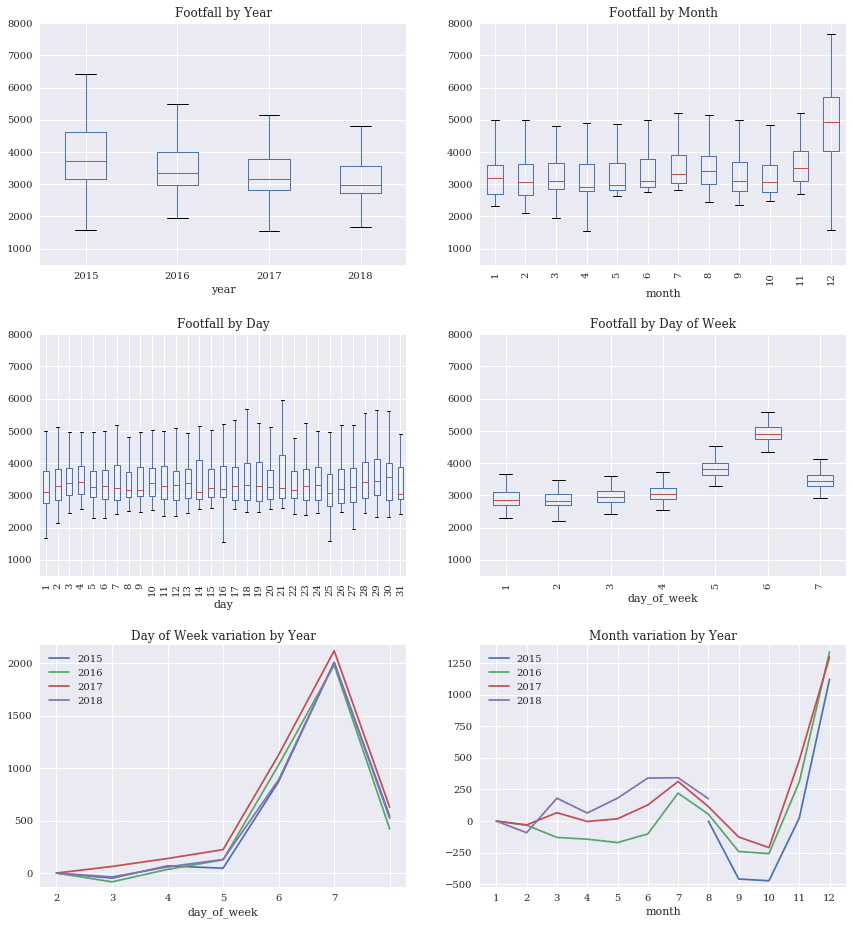

In [50]:
# Plot Stats using predicted values
model_1.plot_graphs(model_1.data_d, col='y_pred')

Plots of footfall in the test (OOT) data using the predicted values. We notice that the model is able to capture most of the trends.

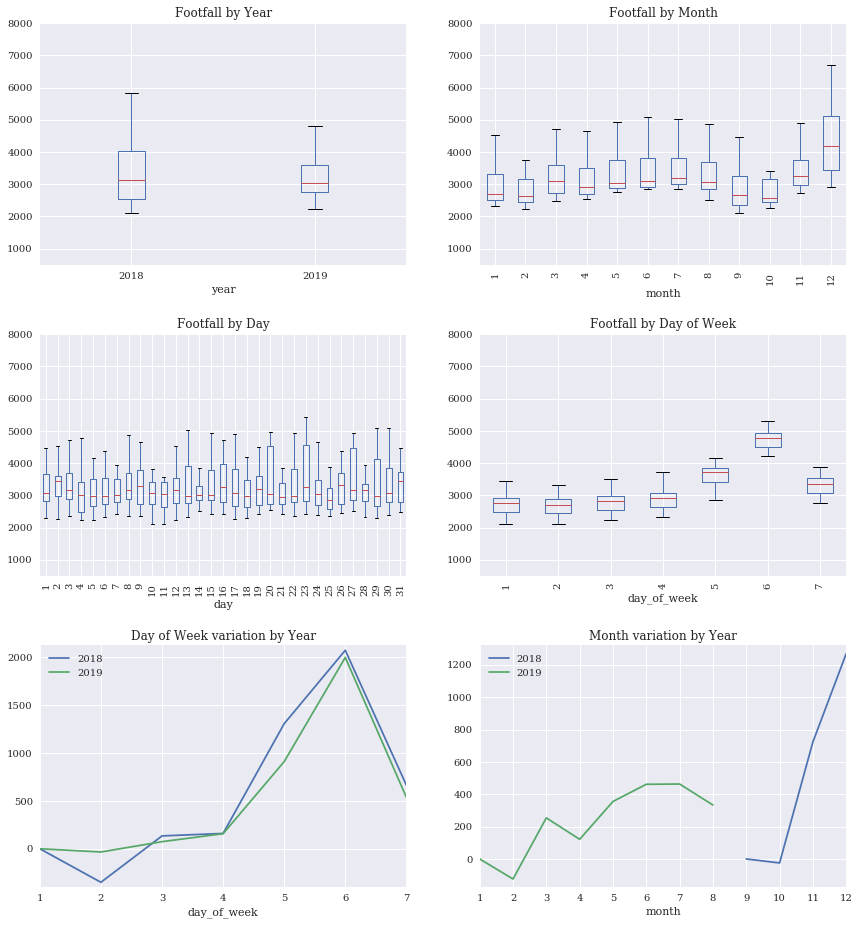

In [28]:
model_1.plot_graphs(model_1.data_t, col='y_pred')